# Federated Learning Model Evaluation Across Data Partitions

This notebook evaluates BiSeNetV2 models trained with different federated learning aggregators (FedAvg, FedProx) across multiple communication rounds and client data partitions. It calculates mIoU and F1-score metrics for each client and visualizes the progression of these metrics across communication round batches.

## Section 1: Import Required Libraries

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Add project root to path
sys.path.insert(0, '/home/moustafa/Me/Projects/Grad/Code/BiseNet-FL/fl-cityscapes-bisenetv2/')

# Import from the project
from lib.models import BiSeNetV2
from lib.data import get_data_loader
import lib.data.transform_cv2 as T
from fl_cityscapes_bisenetv2.data_preparation.client_dataset import CityScapesClientDataset
from tools.eval_metrics import compute_metrics_from_cm

print("Libraries imported successfully!")

Libraries imported successfully!


## Section 2: Define Model Loading and Evaluation Functions

In [2]:
class MetricsCalculator:
    """Calculate semantic segmentation metrics from predictions and labels."""
    
    def __init__(self, n_classes, ignore_label=255):
        self.n_classes = n_classes
        self.ignore_label = ignore_label
        self.confusion_matrix = np.zeros((n_classes, n_classes))
    
    def update(self, predictions, labels):
        """Update confusion matrix with new predictions and labels."""
        # Ensure inputs are numpy arrays
        predictions = predictions.cpu().numpy() if isinstance(predictions, torch.Tensor) else predictions
        labels = labels.cpu().numpy() if isinstance(labels, torch.Tensor) else labels
        
        # Flatten and remove ignore label
        predictions = predictions.flatten()
        labels = labels.flatten()
        
        mask = labels != self.ignore_label
        predictions = predictions[mask]
        labels = labels[mask]
        
        # Update confusion matrix
        np.add.at(
            self.confusion_matrix,
            (labels, predictions),
            1
        )
    
    def compute_metrics(self) -> Dict[str, float]:
        """Compute mIoU and F1-score from confusion matrix."""
        return compute_metrics_from_cm(self.confusion_matrix)
    
    def reset(self):
        """Reset confusion matrix."""
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))


def load_model(model_path: str, n_classes: int = 19, device: str = 'cuda') -> BiSeNetV2:
    """Load BiSeNetV2 model from checkpoint."""
    model = BiSeNetV2(n_classes, aux_mode='eval')
    
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint, strict=False)
        print(f"✓ Model loaded from {model_path}")
    else:
        print(f"✗ Model path not found: {model_path}")
        return None
    
    model = model.to(device)
    model.eval()
    return model


def load_client_dataset(
    im_root: str,
    partition_file: str,
    partition_id: str,
    n_classes: int = 19,
    batch_size: int = 4
):
    """Load client dataset for evaluation."""
    try:
        with open(partition_file, 'r', encoding='utf-8') as f:
            data_partitions = json.load(f)
        
        partition = data_partitions[str(partition_id)]
        
        # Get normalization metrics for this partition
        normalization_metrics = partition.get("data_metrics", {})
        
        ds = CityScapesClientDataset(
            im_root,
            partition["data"],
            normalization_metrics,
            T.TransformationVal()
        )
        
        from torch.utils.data import DataLoader
        dataloader = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        return dataloader, len(ds)
    except Exception as e:
        print(f"Error loading client {partition_id} data: {e}")
        return None, 0


@torch.no_grad()
def evaluate_model_on_client(
    model: BiSeNetV2,
    dataloader,
    n_classes: int = 19,
    device: str = 'cuda',
    return_confusion_matrix: bool = False
) -> Dict[str, float]:
    """Evaluate model on client dataset.
    
    Args:
        return_confusion_matrix: If True, return both metrics and confusion matrix.
                                Returns (metrics_dict, confusion_matrix) tuple.
                                If False, returns only metrics_dict.
    """
    if model is None or dataloader is None:
        return None
    
    metrics_calc = MetricsCalculator(n_classes, ignore_label=255)
    model.eval()
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            logits = outputs[0]  # BiSeNetV2 returns (main_output, aux_outputs...)
            
            # Get predictions
            predictions = torch.argmax(logits, dim=1)
            
            # Update metrics
            metrics_calc.update(predictions, labels.squeeze(1))
    
    metrics = metrics_calc.compute_metrics()
    
    if return_confusion_matrix:
        return metrics, metrics_calc.confusion_matrix
    return metrics

print("Model loading and evaluation functions defined successfully!")

Model loading and evaluation functions defined successfully!


## Section 3: Set Up Directory Paths and Configuration

In [3]:
# ============================================================================
# CONFIGURATION - Modify these paths according to your directory structure
# ============================================================================

PROJECT_ROOT = Path('/home/moustafa/Me/Projects/Grad/Code/BiseNet-FL')
RESULTS_ROOT = Path('/home/moustafa/Me/Projects/Grad/Experiments/City_Partitions')  # Adjust as needed
DATA_ROOT = PROJECT_ROOT / 'datasets' / 'cityscapes'


PARTITION_ID = "City_Partitions"
PARTITION_CLIENTS = 3

# Data partition configuration
DATA_PARTITION_FILE = DATA_ROOT / 'city_partitions.json'
NUM_CLASSES = 19  # Cityscapes has 19 semantic classes

# Aggregators to evaluate
AGGREGATORS = ['FedAvg']  # Add more aggregators if available

# Device configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Batch size for evaluation
EVAL_BATCH_SIZE = 4

# ============================================================================
# Verify Paths and List Available Models
# ============================================================================

print(f"\n{'='*60}")
print("Path Configuration")
print(f"{'='*60}")
print(f"Project Root: {PROJECT_ROOT}")
print(f"Results Root: {RESULTS_ROOT}")
print(f"Data Root: {DATA_ROOT}")
print(f"Data Partition File: {DATA_PARTITION_FILE}")
# print(f"Number of Partitions: {NUM_PARTITIONS}")
print(f"Aggregators: {AGGREGATORS}")
# print(f"Communication Round Batches: {COMMUNICATION_ROUND_BATCHES}")

# List available models
print(f"\n{'='*60}")
print("Discovering Available Models")
print(f"{'='*60}")

available_models = {}
    
for aggregator in AGGREGATORS:
    aggregator_key = aggregator
    available_models[aggregator_key] = []
        
    # Try to find model directories
    base_path = RESULTS_ROOT / aggregator / 'new'
        
    if base_path.exists():
        print(f"\n✓ Found models at: {base_path}")
        # List subdirectories (communication round batches)
        for item in sorted(base_path.iterdir()):
            if item.is_dir() and item.name.isdigit():
                round_num = int(item.name)
                latest_model = item / 'latest_model.pt'
                if latest_model.exists():
                    available_models[aggregator_key].append(round_num)
                    print(f"  └─ Round {round_num}: ✓ latest_model.pt found")
                else:
                    print(f"  └─ Round {round_num}: ✗ latest_model.pt NOT found")
    else:
        print(f"\n✗ No models found for aggregator {aggregator} at expected path: {base_path}")

    if not available_models[aggregator_key]:
        print(f"  ✗ No models found for aggregator {aggregator}")

print("\n" + "="*60)
print("Configuration Complete. Ready for model evaluation.")
print("="*60)

Using device: cuda

Path Configuration
Project Root: /home/moustafa/Me/Projects/Grad/Code/BiseNet-FL
Results Root: /home/moustafa/Me/Projects/Grad/Experiments/City_Partitions
Data Root: /home/moustafa/Me/Projects/Grad/Code/BiseNet-FL/datasets/cityscapes
Data Partition File: /home/moustafa/Me/Projects/Grad/Code/BiseNet-FL/datasets/cityscapes/city_partitions.json
Aggregators: ['FedAvg']

Discovering Available Models

✓ Found models at: /home/moustafa/Me/Projects/Grad/Experiments/City_Partitions/FedAvg/new
  └─ Round 120: ✓ latest_model.pt found
  └─ Round 180: ✓ latest_model.pt found
  └─ Round 240: ✓ latest_model.pt found
  └─ Round 300: ✓ latest_model.pt found
  └─ Round 360: ✓ latest_model.pt found
  └─ Round 420: ✓ latest_model.pt found
  └─ Round 480: ✓ latest_model.pt found
  └─ Round 540: ✓ latest_model.pt found
  └─ Round 60: ✓ latest_model.pt found

Configuration Complete. Ready for model evaluation.


## Section 4: Load Models and Evaluate Per Client

In [4]:
# ============================================================================
# Evaluation Loop: Iterate through all configurations
# ============================================================================

# Storage for evaluation results (includes confusion matrices for per-class analysis)
evaluation_results = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

def find_model_base_path(aggregator: str) -> Optional[Path]:
    """Find the base path for models of a specific partition and aggregator."""
    possible_path = RESULTS_ROOT / aggregator / 'new'
    
    if possible_path.exists():
        return possible_path
    return None


print(f"\n{'='*70}")
print("STARTING MODEL EVALUATION ACROSS ALL CONFIGURATIONS")
print(f"{'='*70}")

# Track which models were actually evaluated
evaluated_configs = []

for aggregator in AGGREGATORS:
    base_path = find_model_base_path(aggregator)
    
    if base_path is None:
        print(f"\n[ERROR] Partition {PARTITION_ID}, {aggregator}: No model directory found")
        continue

    print(f"\n{'-'*70}")
    print(f"Evaluating: Partition {PARTITION_ID} | Aggregator: {aggregator}")
    print(f"Base Path: {base_path}")
    print(f"{'-'*70}")
    
    # Get available communication round directories
    round_dirs = sorted([
        int(d.name) for d in base_path.iterdir() 
        if d.is_dir() and d.name.isdigit()
    ])
    
    if not round_dirs:
        print(f"✗ No communication round directories found")
        continue
    
    print(f"Found rounds: {round_dirs}")
    
    for comm_round in round_dirs:
        round_path = base_path / str(comm_round)
        latest_model_path = round_path / 'latest_model.pt'

        if not latest_model_path.exists():
            print(f"  ✗ Round {comm_round}: latest_model.pt not found")
            continue
        
        print(f"\n  Loading model for round {comm_round}...")
        model = load_model(str(latest_model_path), n_classes=NUM_CLASSES, device=DEVICE)
        
        if model is None:
            continue
        
        # Evaluate on each client
        for client_id in range(PARTITION_CLIENTS):
            try:
                # Load client dataset
                dataloader, num_samples = load_client_dataset(
                    str(DATA_ROOT),
                    str(DATA_PARTITION_FILE),
                    client_id,
                    n_classes=NUM_CLASSES,
                    batch_size=EVAL_BATCH_SIZE
                )
                
                if dataloader is None:
                    continue
                
                # Evaluate model on client data (collect confusion matrix for per-class analysis)
                metrics, confusion_matrix = evaluate_model_on_client(
                    model,
                    dataloader,
                    n_classes=NUM_CLASSES,
                    device=DEVICE,
                    return_confusion_matrix=True
                )
                
                if metrics is not None:
                    # Store results with confusion matrix for per-class analysis
                    evaluation_results[aggregator][client_id][comm_round] = {
                        'metrics': metrics,
                        'confusion_matrix': confusion_matrix
                    }
                    
                    miou = metrics.get('mIoU', 0.0)
                    f1 = metrics.get('F1_Score', 0.0)
                    
                    print(f"    Client {client_id}: mIoU={miou:.4f}, F1={f1:.4f} ({num_samples} samples)")
                
            except Exception as e:
                print(f"    ✗ Error evaluating client {client_id}: {str(e)}")
        
        # Free memory
        del model
        torch.cuda.empty_cache()
    
    # Best model evaluation
    best_round_path = base_path / str(round_dirs[-1])
    best_model_path = best_round_path / 'best_model.pt'
    comm_round = "Best"
    if not best_model_path.exists():
        best_model_path = base_path / str(round_dirs[-2]) / 'latest_model.pt'

    print(f"\n  Loading model for round {comm_round}...")
    model = load_model(str(best_model_path), n_classes=NUM_CLASSES, device=DEVICE)
    
    # Evaluate on each client
    for client_id in range(PARTITION_CLIENTS):
        try:
            # Load client dataset
            dataloader, num_samples = load_client_dataset(
                str(DATA_ROOT),
                str(DATA_PARTITION_FILE),
                client_id,
                n_classes=NUM_CLASSES,
                batch_size=EVAL_BATCH_SIZE
            )
            
            if dataloader is None:
                continue
            
            # Evaluate model on client data (collect confusion matrix for per-class analysis)
            metrics, confusion_matrix = evaluate_model_on_client(
                model,
                dataloader,
                n_classes=NUM_CLASSES,
                device=DEVICE,
                return_confusion_matrix=True
            )
            
            if metrics is not None:
                # Store results with confusion matrix for per-class analysis
                evaluation_results[aggregator][client_id][comm_round] = {
                    'metrics': metrics,
                    'confusion_matrix': confusion_matrix
                }
                
                miou = metrics.get('mIoU', 0.0)
                f1 = metrics.get('F1_Score', 0.0)
                
                print(f"    Client {client_id}: mIoU={miou:.4f}, F1={f1:.4f} ({num_samples} samples)")
            
        except Exception as e:
            print(f"    ✗ Error evaluating client {client_id}: {str(e)}")
    
    # Free memory
    del model
    torch.cuda.empty_cache()

    evaluated_configs.append((PARTITION_ID, aggregator))

print(f"\n{'='*70}")
print("EVALUATION COMPLETE")
print(f"Configurations evaluated: {len(evaluated_configs)}")
print(f"{'='*70}")


STARTING MODEL EVALUATION ACROSS ALL CONFIGURATIONS

----------------------------------------------------------------------
Evaluating: Partition City_Partitions | Aggregator: FedAvg
Base Path: /home/moustafa/Me/Projects/Grad/Experiments/City_Partitions/FedAvg/new
----------------------------------------------------------------------
Found rounds: [60, 120, 180, 240, 300, 360, 420, 480, 540]

  Loading model for round 60...
✓ Model loaded from /home/moustafa/Me/Projects/Grad/Experiments/City_Partitions/FedAvg/new/60/latest_model.pt


    Client 0: mIoU=0.3952, F1=0.4637 (174 samples)


    Client 1: mIoU=0.3904, F1=0.4637 (96 samples)


    Client 2: mIoU=0.4043, F1=0.4740 (316 samples)

  Loading model for round 120...
✓ Model loaded from /home/moustafa/Me/Projects/Grad/Experiments/City_Partitions/FedAvg/new/120/latest_model.pt


    Client 0: mIoU=0.4833, F1=0.5704 (174 samples)


    Client 1: mIoU=0.4854, F1=0.5775 (96 samples)


    Client 2: mIoU=0.5182, F1=0.6046 (316 samples)

  Loading model for round 180...
✓ Model loaded from /home/moustafa/Me/Projects/Grad/Experiments/City_Partitions/FedAvg/new/180/latest_model.pt


    Client 0: mIoU=0.5421, F1=0.6424 (174 samples)


    Client 1: mIoU=0.5496, F1=0.6630 (96 samples)


    Client 2: mIoU=0.6125, F1=0.7195 (316 samples)

  Loading model for round 240...
✓ Model loaded from /home/moustafa/Me/Projects/Grad/Experiments/City_Partitions/FedAvg/new/240/latest_model.pt


    Client 0: mIoU=0.5709, F1=0.6698 (174 samples)


    Client 1: mIoU=0.6312, F1=0.7538 (96 samples)


    Client 2: mIoU=0.6654, F1=0.7757 (316 samples)

  Loading model for round 300...
✓ Model loaded from /home/moustafa/Me/Projects/Grad/Experiments/City_Partitions/FedAvg/new/300/latest_model.pt


    Client 0: mIoU=0.6184, F1=0.7183 (174 samples)


    Client 1: mIoU=0.6497, F1=0.7635 (96 samples)


    Client 2: mIoU=0.6925, F1=0.8035 (316 samples)

  Loading model for round 360...
✓ Model loaded from /home/moustafa/Me/Projects/Grad/Experiments/City_Partitions/FedAvg/new/360/latest_model.pt


    Client 0: mIoU=0.6298, F1=0.7304 (174 samples)


    Client 1: mIoU=0.6599, F1=0.7693 (96 samples)


    Client 2: mIoU=0.6944, F1=0.8061 (316 samples)

  Loading model for round 420...
✓ Model loaded from /home/moustafa/Me/Projects/Grad/Experiments/City_Partitions/FedAvg/new/420/latest_model.pt


    Client 0: mIoU=0.6437, F1=0.7451 (174 samples)


    Client 1: mIoU=0.6750, F1=0.7872 (96 samples)


    Client 2: mIoU=0.7312, F1=0.8355 (316 samples)

  Loading model for round 480...
✓ Model loaded from /home/moustafa/Me/Projects/Grad/Experiments/City_Partitions/FedAvg/new/480/latest_model.pt


    Client 0: mIoU=0.6460, F1=0.7472 (174 samples)


    Client 1: mIoU=0.6892, F1=0.8001 (96 samples)


    Client 2: mIoU=0.7472, F1=0.8472 (316 samples)

  Loading model for round 540...
✓ Model loaded from /home/moustafa/Me/Projects/Grad/Experiments/City_Partitions/FedAvg/new/540/latest_model.pt


    Client 0: mIoU=0.6476, F1=0.7488 (174 samples)


    Client 1: mIoU=0.6915, F1=0.8020 (96 samples)


    Client 2: mIoU=0.7463, F1=0.8468 (316 samples)

  Loading model for round Best...
✓ Model loaded from /home/moustafa/Me/Projects/Grad/Experiments/City_Partitions/FedAvg/new/540/best_model.pt


    Client 0: mIoU=0.6495, F1=0.7502 (174 samples)


    Client 1: mIoU=0.6887, F1=0.7983 (96 samples)


    Client 2: mIoU=0.7386, F1=0.8414 (316 samples)

EVALUATION COMPLETE
Configurations evaluated: 1


## Section 5: Aggregate Metrics Across Communication Rounds

In [5]:
def aggregate_and_prepare_plot_data(
    evaluation_results,
    aggregator: str,
    metric: str = 'mIoU'
) -> Tuple[Dict, Dict]:
    """
    Aggregate evaluation results for plotting.
    Handles both old format (direct metrics) and new format (metrics + confusion_matrix).
    
    Returns:
        plot_data: {client_id: {round: metric_value}}
    """
    plot_data = defaultdict(dict)
    
    if aggregator not in evaluation_results:
        return dict(plot_data)
    
    agg_results = evaluation_results[aggregator]
    
    for client_id in agg_results:
        client_data = agg_results[client_id]
        
        # Store metric values for each communication round
        for comm_round in client_data.keys():
            result = client_data[comm_round]
            
            # Handle new format: {'metrics': {...}, 'confusion_matrix': ...}
            if isinstance(result, dict) and 'metrics' in result:
                metrics = result['metrics']
            else:
                # Handle old format: direct metrics dict
                metrics = result
            
            if metric in metrics:
                plot_data[client_id][comm_round] = metrics[metric]
    
    return dict(plot_data)


# Process results for each partition and aggregator
processed_results = {}

for aggregator in evaluation_results:
    processed_results[aggregator] = {}
    
    # Prepare data for both metrics
    miou_data = aggregate_and_prepare_plot_data(
            evaluation_results, aggregator, metric='mIoU'
    )
    f1_data = aggregate_and_prepare_plot_data(
        evaluation_results, aggregator, metric='F1_Score'
    )

    processed_results[aggregator] = {
        'mIoU': {
            'data': miou_data,
        },
        'F1_Score': {
            'data': f1_data,
        }
    }

print("Metrics aggregated and prepared for visualization!")
print(f"\nProcessed results for {len(processed_results)} partitions")

# Display summary statistics
print(f"\n{'='*70}")
print("EVALUATION SUMMARY")

Metrics aggregated and prepared for visualization!

Processed results for 1 partitions

EVALUATION SUMMARY


## Section 6: Visualize Client Performance with Bar Plots


Generating plots for Partition City_Partitions


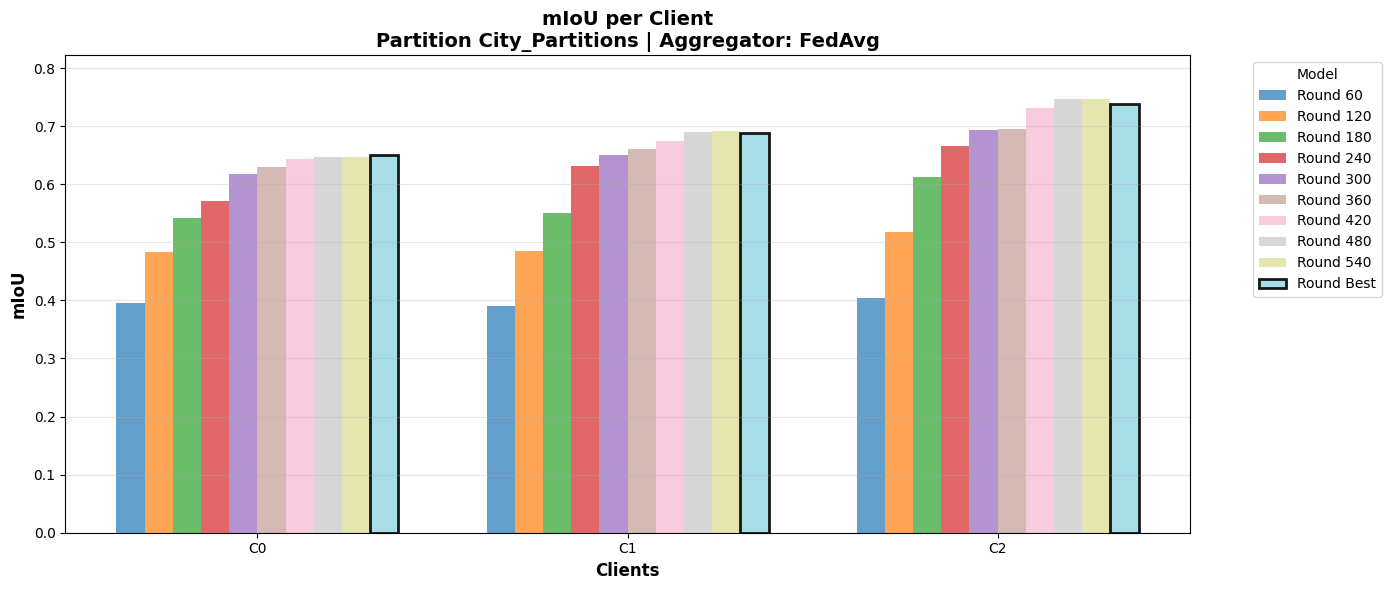

  ✓ Saved: miou_partition_City_Partitions_FedAvg.png


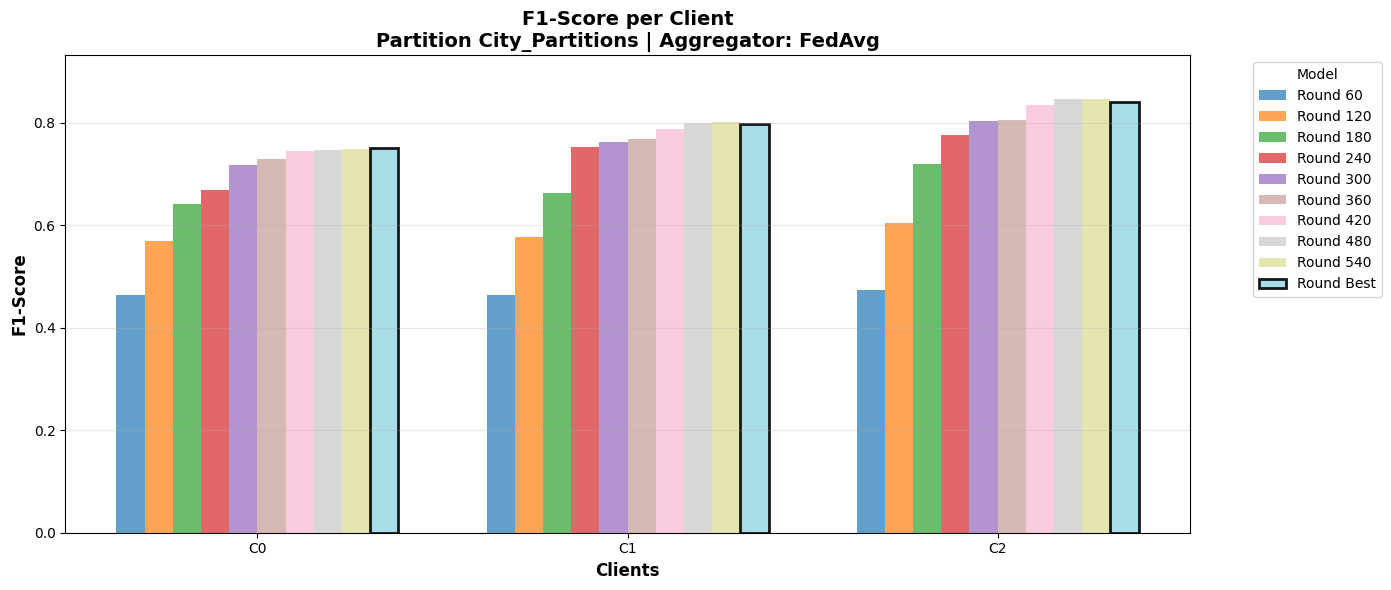

  ✓ Saved: f1score_partition_City_Partitions_FedAvg.png

VISUALIZATION COMPLETE: 2 plots generated


In [6]:
def plot_client_metrics(
    plot_data: Dict,
    metric_name: str = 'mIoU',
    aggregator: str = 'FedAvg',
    figsize: Tuple[int, int] = (14, 6)
):
    """
    Create a grouped bar plot for client performance across communication rounds.
    
    Args:
        plot_data: {client_id: {round: metric_value}}
        metric_name: Name of the metric being plotted
        aggregator: Name of the aggregator
        partition_id: ID of the data partition
        figsize: Figure size tuple
    """
    if not plot_data:
        print(f"No data to plot for {aggregator}, Partition {PARTITION_ID}")
        return
    
    # Prepare data for plotting
    client_ids = sorted(plot_data.keys())
    all_rounds = [r for client_rounds in plot_data.values() for r in client_rounds.keys()]
    
    # Create dataframe for easier plotting
    plot_df_list = []
    for client_id in client_ids:
        client_rounds = plot_data[client_id]
        for round_num in all_rounds:
            value = client_rounds.get(round_num, None)
            if value is not None:
                plot_df_list.append({
                    'Client': f'Client {client_id}',
                    'Communication Round': round_num,
                    metric_name: value,
                    'Model Type': f'Round {round_num}'
                })
        
    if not plot_df_list:
        print(f"No valid data points for plotting")
        return
    
    plot_df = pd.DataFrame(plot_df_list)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique rounds for coloring
    rounds_and_best = sorted(
        set(plot_df['Model Type']),
        key=lambda x: (x == 'Round Best', int(x.split()[-1]) if x != 'Round Best' else float('inf'))
    )
    colors = plt.cm.tab20(np.linspace(0, 1, len(rounds_and_best)))
    color_map = {r: colors[i] for i, r in enumerate(rounds_and_best)}
    
    # Create grouped bar plot
    x = np.arange(len(client_ids))
    width = 0.8 / (len(rounds_and_best) + 0.5)
    
    for idx, model_type in enumerate(rounds_and_best):
        data_subset = plot_df[plot_df['Model Type'] == model_type]
        values = [
            data_subset[data_subset['Client'] == f'Client {cid}'][metric_name].values[0]
            if len(data_subset[data_subset['Client'] == f'Client {cid}']) > 0
            else 0
            for cid in client_ids
        ]
        
        offset = (idx - len(rounds_and_best)/2 + 0.5) * width

        # Highlight 'Round Best' bar differently
        if model_type == 'Round Best':
            ax.bar(x + offset, values, width, label=model_type, 
                  color=color_map[model_type], edgecolor='black', linewidth=2, alpha=0.9)
        else:
            ax.bar(x + offset, values, width, label=model_type, 
                  color=color_map[model_type], alpha=0.7)
    
    # Customize plot
    ax.set_xlabel('Clients', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric_name, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric_name} per Client\nPartition {PARTITION_ID} | Aggregator: {aggregator}', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'C{cid}' for cid in client_ids])
    ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, max(plot_df[metric_name]) * 1.1])
    
    plt.tight_layout()
    return fig, ax


# Generate plots for each partition and aggregator
plots_generated = 0

print(f"\n{'='*70}")
print(f"Generating plots for Partition {PARTITION_ID}")
print(f"{'='*70}")

for aggregator in sorted(processed_results.keys()):
    # Plot mIoU
    miou_data = processed_results[aggregator]['mIoU']['data']

    if miou_data:
        fig, ax = plot_client_metrics(
            miou_data,
            metric_name='mIoU',
            aggregator=aggregator,
        )
        plt.savefig(
            f'miou_partition_{PARTITION_ID}_{aggregator}.png',
            dpi=150,
            bbox_inches='tight'
        )
        plt.show()
        plots_generated += 1
        print(f"  ✓ Saved: miou_partition_{PARTITION_ID}_{aggregator}.png")

    # Plot F1-Score
    f1_data = processed_results[aggregator]['F1_Score']['data']

    if f1_data:
        fig, ax = plot_client_metrics(
            f1_data,
            metric_name='F1-Score',
            aggregator=aggregator,
        )
        plt.savefig(
            f'f1score_partition_{PARTITION_ID}_{aggregator}.png',
            dpi=150,
            bbox_inches='tight'
        )
        plt.show()
        plots_generated += 1
        print(f"  ✓ Saved: f1score_partition_{PARTITION_ID}_{aggregator}.png")

print(f"\n{'='*70}")
print(f"VISUALIZATION COMPLETE: {plots_generated} plots generated")
print(f"{'='*70}")

## Section 7: Variance Analysis - Client Heterogeneity Across Communication Rounds


In [8]:
def calculate_variance_metrics(evaluation_results):
    """
    Calculate Coefficient of Variation (CoV) of mIoU across clients for each round.
    Handles both old format (direct metrics) and new format (metrics + confusion_matrix).
    
    Returns:
        variance_data: {aggregator: {round: {'mean': float, 'std': float, 'cov': float}}}
    """
    variance_data = defaultdict(lambda: defaultdict(dict))
    
    for aggregator in evaluation_results:
        client_results = evaluation_results[aggregator]
        
        # Get all unique rounds
        all_rounds = set()
        for client_id in client_results:
            all_rounds.update(client_results[client_id].keys())
        
        # Calculate variance for each round
        for comm_round in sorted(all_rounds, key=lambda x: (x == 'Best', int(x) if isinstance(x, int) else float('inf'))):
            round_metrics = []
            
            for client_id in client_results:
                if comm_round in client_results[client_id]:
                    result = client_results[client_id][comm_round]
                    
                    # Handle new format: {'metrics': {...}, 'confusion_matrix': ...}
                    if isinstance(result, dict) and 'metrics' in result:
                        metrics = result['metrics']
                    else:
                        # Handle old format: direct metrics dict
                        metrics = result
                    
                    miou = metrics.get('mIoU', None)
                    if miou is not None:
                        round_metrics.append(miou)
            
            if round_metrics:
                mean_miou = np.mean(round_metrics)
                std_miou = np.std(round_metrics)
                cov = (std_miou / mean_miou * 100) if mean_miou > 0 else 0  # CoV as percentage
                
                variance_data[aggregator][comm_round] = {
                    'mean': mean_miou,
                    'std': std_miou,
                    'cov': cov,
                    'num_clients': len(round_metrics)
                }
    
    return dict(variance_data)


# Calculate variance metrics
variance_metrics = calculate_variance_metrics(evaluation_results)

print(f"\n{'='*70}")
print("CLIENT HETEROGENEITY ANALYSIS (Coefficient of Variation)")
print(f"{'='*70}")

variance_summary = []

for aggregator in sorted(variance_metrics.keys()):
    print(f"\n{aggregator}:")
    for comm_round in sorted(variance_metrics[aggregator].keys(), 
                             key=lambda x: (x == 'Best', int(x) if isinstance(x, int) else float('inf'))):
        metrics = variance_metrics[aggregator][comm_round]
        print(f"  Round {comm_round:>4}: "
              f"Mean mIoU = {metrics['mean']:.4f}, "
              f"Std = {metrics['std']:.4f}, "
              f"CoV = {metrics['cov']:.2f}% "
              f"({metrics['num_clients']} clients)")
        
        variance_summary.append({
            'Partition': PARTITION_ID,
            'Aggregator': aggregator,
            'Communication_Round': comm_round,
            'Mean_mIoU': metrics['mean'],
            'Std_mIoU': metrics['std'],
            'CoV_mIoU': metrics['cov'],
            'Num_Clients': metrics['num_clients']
        })

print("\n✓ Variance metrics calculated!")


CLIENT HETEROGENEITY ANALYSIS (Coefficient of Variation)

FedAvg:
  Round   60: Mean mIoU = 0.3967, Std = 0.0058, CoV = 1.46% (3 clients)
  Round  120: Mean mIoU = 0.4956, Std = 0.0160, CoV = 3.22% (3 clients)
  Round  180: Mean mIoU = 0.5681, Std = 0.0316, CoV = 5.56% (3 clients)
  Round  240: Mean mIoU = 0.6225, Std = 0.0391, CoV = 6.28% (3 clients)
  Round  300: Mean mIoU = 0.6536, Std = 0.0304, CoV = 4.65% (3 clients)
  Round  360: Mean mIoU = 0.6613, Std = 0.0264, CoV = 3.99% (3 clients)
  Round  420: Mean mIoU = 0.6833, Std = 0.0362, CoV = 5.30% (3 clients)
  Round  480: Mean mIoU = 0.6941, Std = 0.0414, CoV = 5.97% (3 clients)
  Round  540: Mean mIoU = 0.6951, Std = 0.0404, CoV = 5.81% (3 clients)
  Round Best: Mean mIoU = 0.6922, Std = 0.0365, CoV = 5.27% (3 clients)

✓ Variance metrics calculated!



Generating Variance Trend Plots


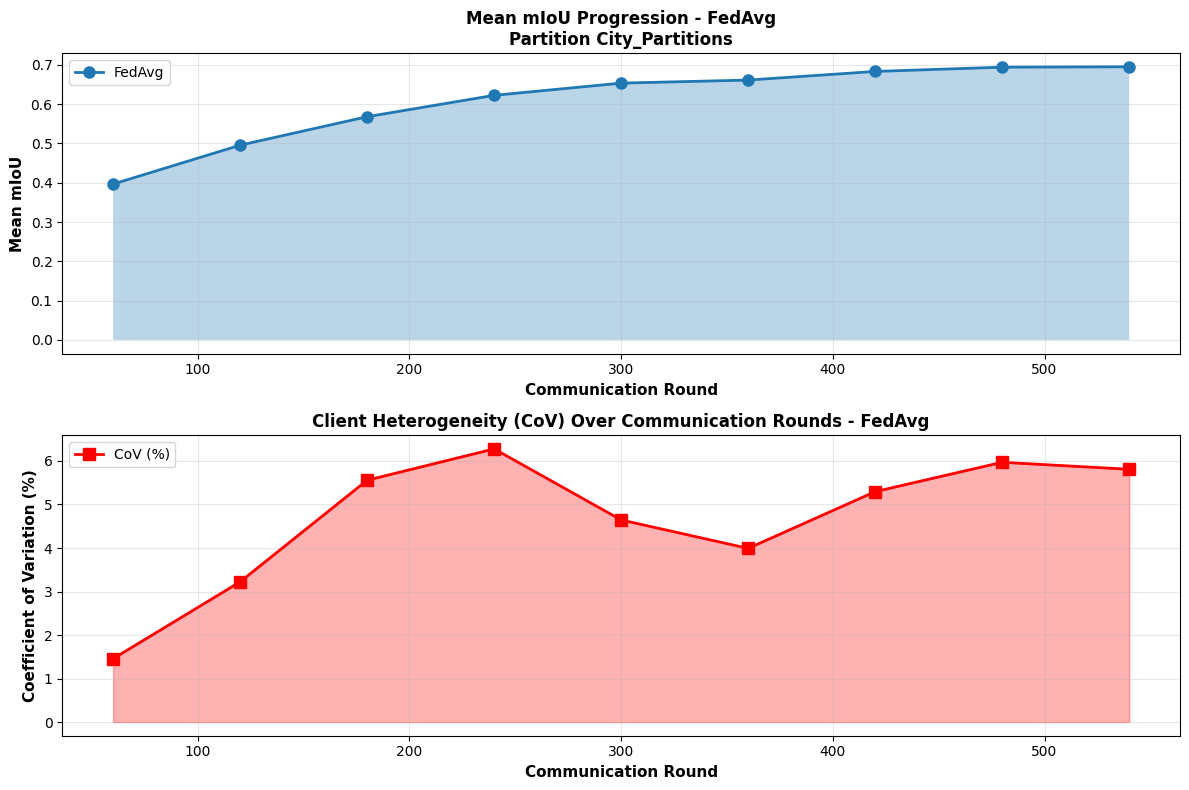

  ✓ Saved: variance_trends_partition_City_Partitions_FedAvg.png
✓ Variance trend plots generated!


In [9]:
# Plot variance trends across communication rounds
print(f"\n{'='*70}")
print(f"Generating Variance Trend Plots")
print(f"{'='*70}")

for aggregator in sorted(variance_metrics.keys()):
    metrics_by_round = variance_metrics[aggregator]
    
    # Extract data, excluding 'Best' for numeric sorting
    numeric_rounds = []
    means = []
    covs = []
    
    for comm_round in sorted(metrics_by_round.keys(), 
                             key=lambda x: (x == 'Best', int(x) if isinstance(x, int) else float('inf'))):
        if comm_round != 'Best':
            numeric_rounds.append(int(comm_round))
            means.append(metrics_by_round[comm_round]['mean'])
            covs.append(metrics_by_round[comm_round]['cov'])
    
    if numeric_rounds:
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        
        # Plot 1: Mean mIoU trend
        axes[0].plot(numeric_rounds, means, marker='o', linewidth=2, markersize=8, label=aggregator)
        axes[0].fill_between(numeric_rounds, means, alpha=0.3)
        axes[0].set_xlabel('Communication Round', fontsize=11, fontweight='bold')
        axes[0].set_ylabel('Mean mIoU', fontsize=11, fontweight='bold')
        axes[0].set_title(f'Mean mIoU Progression - {aggregator}\nPartition {PARTITION_ID}', 
                         fontsize=12, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()
        
        # Plot 2: Coefficient of Variation trend
        axes[1].plot(numeric_rounds, covs, marker='s', linewidth=2, markersize=8, color='red', label='CoV (%)')
        axes[1].fill_between(numeric_rounds, covs, alpha=0.3, color='red')
        axes[1].set_xlabel('Communication Round', fontsize=11, fontweight='bold')
        axes[1].set_ylabel('Coefficient of Variation (%)', fontsize=11, fontweight='bold')
        axes[1].set_title(f'Client Heterogeneity (CoV) Over Communication Rounds - {aggregator}', 
                         fontsize=12, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()
        
        plt.tight_layout()
        plt.savefig(f'variance_trends_partition_{PARTITION_ID}_{aggregator}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"  ✓ Saved: variance_trends_partition_{PARTITION_ID}_{aggregator}.png")

print("✓ Variance trend plots generated!")


## Section 8: Per-Class Performance Analysis - Label Skew Detection


In [ ]:
# Cityscapes class names (19 classes)
CITYSCAPES_CLASSES = [
    'road', 'sidewalk', 'building', 'wall', 'fence',
    'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain',
    'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle'
]

def compute_per_class_iou(evaluation_results, aggregator, comm_round):
    """
    Compute per-class IoU for each client at a specific round.
    Uses pre-computed confusion matrices from evaluation results.
    
    Returns:
        per_class_data: {client_id: [iou_class_0, iou_class_1, ...]}
    """
    per_class_data = {}
    
    if aggregator not in evaluation_results:
        return per_class_data
    
    agg_data = evaluation_results[aggregator]
    
    for client_id in agg_data:
        if comm_round not in agg_data[client_id]:
            continue
        
        client_result = agg_data[client_id][comm_round]
        
        # Extract confusion matrix (can be stored as dict with 'confusion_matrix' key or directly)
        if isinstance(client_result, dict) and 'confusion_matrix' in client_result:
            client_cm = client_result['confusion_matrix']
        elif isinstance(client_result, dict) and 'metrics' in client_result:
            # If only metrics are stored, skip
            continue
        else:
            continue
        
        # Compute per-class IoU from confusion matrix
        per_class_iou = []
        for class_id in range(NUM_CLASSES):
            tp = client_cm[class_id, class_id]
            fp = np.sum(client_cm[:, class_id]) - tp
            fn = np.sum(client_cm[class_id, :]) - tp
            
            iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
            per_class_iou.append(iou)
        
        per_class_data[client_id] = per_class_iou
    
    return per_class_data


def create_per_class_heatmap(per_class_data, aggregator, comm_round, partition_id, output_dir=None):
    """Create and save per-class IoU heatmap for a given aggregator/round.
    
    Heatmap Values: Per-Class IoU (Intersection over Union)
    - Blue (high): Client learned that class well (high IoU)
    - Red (low): Client poorly learned class or missing in data (low IoU, label skew)
    """
    if not per_class_data:
        return
    
    # Sort clients by ID for consistent visualization
    client_ids = sorted(per_class_data.keys())
    
    # Create heatmap data: rows=clients, columns=classes
    heatmap_matrix = np.array([per_class_data[cid] for cid in client_ids])
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot heatmap with blue-red colormap (blue=high IoU, red=low IoU)
    im = ax.imshow(heatmap_matrix, cmap='coolwarm_r', aspect='auto', vmin=0, vmax=1)
    
    # Set labels
    ax.set_yticks(np.arange(len(client_ids)))
    ax.set_xticks(np.arange(NUM_CLASSES))
    ax.set_yticklabels([f'Client {cid}' for cid in client_ids])
    ax.set_xticklabels(CITYSCAPES_CLASSES, rotation=45, ha='right')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Per-Class IoU', rotation=270, labelpad=20)
    
    # Annotate with IoU values
    for i in range(len(client_ids)):
        for j in range(NUM_CLASSES):
            text = ax.text(j, i, f'{heatmap_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=8)
    
    ax.set_title(f'Per-Class IoU Heatmap - {aggregator} - Round {comm_round}\n(Blue=High IoU/Well-learned, Red=Low IoU/Label Skew)')
    plt.tight_layout()
    
    # Save figure
    if output_dir is None:
        output_dir = Path.cwd()
    else:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
    
    fig_path = output_dir / f'per_class_iou_heatmap_partition_{partition_id}_{aggregator}_round_{comm_round}.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved heatmap: {fig_path.name}")
    plt.close()


Computing Per-Class IoU Metrics

FedAvg:
  Round Best: ✓ Computed per-class IoU for 3 clients
✓ Saved heatmap: per_class_iou_heatmap_partition_City_Partitions_FedAvg_round_Best.png
  Round 60: ✓ Computed per-class IoU for 3 clients
✓ Saved heatmap: per_class_iou_heatmap_partition_City_Partitions_FedAvg_round_60.png
  Round 120: ✓ Computed per-class IoU for 3 clients
✓ Saved heatmap: per_class_iou_heatmap_partition_City_Partitions_FedAvg_round_120.png
  Round 180: ✓ Computed per-class IoU for 3 clients
✓ Saved heatmap: per_class_iou_heatmap_partition_City_Partitions_FedAvg_round_180.png
  Round 240: ✓ Computed per-class IoU for 3 clients
✓ Saved heatmap: per_class_iou_heatmap_partition_City_Partitions_FedAvg_round_240.png
  Round 300: ✓ Computed per-class IoU for 3 clients
✓ Saved heatmap: per_class_iou_heatmap_partition_City_Partitions_FedAvg_round_300.png
  Round 360: ✓ Computed per-class IoU for 3 clients
✓ Saved heatmap: per_class_iou_heatmap_partition_City_Partitions_FedAvg_round_

In [ ]:
# Process per-class metrics for all evaluated rounds
print(f"\n{'='*70}")
print("Generating Per-Class IoU Heatmaps")
print(f"{'='*70}")

per_class_data_all = defaultdict(dict)

for aggregator in sorted(evaluation_results.keys()):
    print(f"\n{aggregator}:")
    
    # Get all available rounds for this aggregator
    all_rounds = set()
    for client_id in evaluation_results[aggregator]:
        all_rounds.update(evaluation_results[aggregator][client_id].keys())
    
    for comm_round in sorted(all_rounds, key=lambda x: (x != "Best", x if isinstance(x, str) else int(x))):
        # Compute per-class IoU for this round
        per_class_data = compute_per_class_iou(evaluation_results, aggregator, comm_round)
        
        if per_class_data:
            # Store for CSV export
            per_class_data_all[aggregator][comm_round] = per_class_data
            
            # Create and save heatmap
            create_per_class_heatmap(per_class_data, aggregator, comm_round, PARTITION_ID)
            print(f"  ✓ Round {comm_round}: Generated heatmap for {len(per_class_data)} clients")

print("\n✓ Per-class heatmaps generated!")


Generating Per-Class IoU Heatmaps


NameError: name 'evaluation_results_with_cm' is not defined

## Section 9: Export All Results (Including Variance and Per-Class Metrics) to CSV


In [ ]:
def export_results_to_csv(evaluation_results, variance_summary, per_class_data_all, output_dir: str = '.'):
    """
    Export evaluation results, variance metrics, and per-class IoU to CSV files.
    """
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # ===== 1. MAIN EVALUATION RESULTS =====
    all_results = []
    
    for aggregator in evaluation_results:
        for client_id in evaluation_results[aggregator]:
            for comm_round in evaluation_results[aggregator][client_id]:
                metrics = evaluation_results[aggregator][client_id][comm_round]

                all_results.append({
                    'Partition': PARTITION_ID,
                    'Aggregator': aggregator,
                    'Client': client_id,
                    'Communication_Round': comm_round,
                    'mIoU': metrics.get('mIoU', None),
                    'F1_Score': metrics.get('F1_Score', None),
                    'Accuracy': metrics.get('Accuracy', None),
                    'Precision': metrics.get('Precision', None),
                    'Recall': metrics.get('Recall', None),
                    'fw_mIoU': metrics.get('fw_mIoU', None),
                })
    
    results_df = pd.DataFrame(all_results)
    csv_path = output_path / 'evaluation_results.csv'
    results_df.to_csv(csv_path, index=False)
    print(f"✓ Results exported to: {csv_path}")
    
    # ===== 2. VARIANCE / CLIENT HETEROGENEITY =====
    if variance_summary:
        variance_df = pd.DataFrame(variance_summary)
        variance_path = output_path / 'variance_analysis.csv'
        variance_df.to_csv(variance_path, index=False)
        print(f"✓ Variance analysis exported to: {variance_path}")
    
    # ===== 3. PER-CLASS IoU HEATMAP DATA =====
    per_class_flat = []
    
    for aggregator in per_class_data_all:
        for comm_round in per_class_data_all[aggregator]:
            per_class_data = per_class_data_all[aggregator][comm_round]
            
            for client_id in per_class_data:
                class_ious = per_class_data[client_id]
                
                row = {
                    'Partition': PARTITION_ID,
                    'Aggregator': aggregator,
                    'Client': client_id,
                    'Communication_Round': comm_round,
                }
                
                # Add per-class IoU as separate columns
                for class_idx, class_name in enumerate(CITYSCAPES_CLASSES):
                    row[f'IoU_{class_name}'] = class_ious[class_idx]
                
                per_class_flat.append(row)
    
    if per_class_flat:
        per_class_df = pd.DataFrame(per_class_flat)
        per_class_path = output_path / 'per_class_iou.csv'
        per_class_df.to_csv(per_class_path, index=False)
        print(f"✓ Per-class IoU data exported to: {per_class_path}")
    
    # ===== 4. SUMMARY STATISTICS =====
    summary_df = results_df.groupby(['Partition', 'Aggregator', 'Client']).agg({
        'mIoU': ['mean', 'std', 'max'],
        'F1_Score': ['mean', 'std', 'max']
    }).round(4)
    
    summary_path = output_path / 'evaluation_summary.csv'
    summary_df.to_csv(summary_path)
    print(f"✓ Summary statistics exported to: {summary_path}")
    
    return results_df, variance_df if variance_summary else None, per_class_df if per_class_flat else None, summary_df

# Export all results
print(f"\n{'='*70}")
print("EXPORTING ALL RESULTS TO CSV")
print(f"{'='*70}\n")

if evaluation_results:
    results_df, variance_df, per_class_df, summary_df = export_results_to_csv(
        evaluation_results, 
        variance_summary, 
        per_class_data_all,
        output_dir='.'
    )
    
    print("\n" + "="*70)
    print("EXPORT SUMMARY")
    print("="*70)
    print(f"Total evaluation records: {len(results_df)}")
    if variance_df is not None:
        print(f"Variance records: {len(variance_df)}")
    if per_class_df is not None:
        print(f"Per-class IoU records: {len(per_class_df)}")
    print("\nCSV files created:")
    print("  - evaluation_results.csv (main metrics)")
    print("  - variance_analysis.csv (CoV trends)")
    print("  - per_class_iou.csv (label skew analysis)")
    print("  - evaluation_summary.csv (aggregated stats)")
else:
    print("No evaluation results to export.")


## Analysis Summary and Interpretation Guide

### 📊 What Each Analysis Reveals:

**1. Variance Analysis (variance_analysis.csv + variance_trends_*.png)**
   - **Metric**: Coefficient of Variation (CoV) = (Std / Mean) × 100
   - **What it shows**: How heterogeneous (unequal) client performance is at each communication round
   - **Interpretation**: 
     - High CoV (>20%) = Clients are performing very differently → strong non-IIDness or label skew
     - Low CoV (<10%) = Clients performing similarly → homogeneous data or good aggregator convergence
     - Decreasing CoV over rounds = Aggregator successfully reducing client heterogeneity (good!)
     - Increasing CoV = Non-IIDness getting worse (possible issue with aggregator)

**2. Per-Class IoU Heatmaps (per_class_iou_heatmap_*.png + per_class_iou.csv)**
   - **Rows**: Clients (C0, C1, C2, ...)
   - **Columns**: Cityscapes classes (road, car, person, bicycle, etc.)
   - **Values**: Per-class IoU (0-1)
   - **What it reveals**:
     - **Bright green cells**: Class well-learned by that client
     - **Red cells**: Class poorly-learned or missing in that client's data
   - **Key insights**:
     - If a column is red for all clients → that class is rare across all partitions
     - If a column is red only for Client A → label skew: that class is underrepresented in Client A's data
     - Different "winning" clients per class → indicates clear label skew across partitions
     - This explains why clients diverge: they're literally learning different object distributions!

**Example scenario**:
- Client 0: Excellent on "car" (0.92 IoU), poor on "bicycle" (0.15 IoU)
- Client 1: Excellent on "bicycle" (0.88 IoU), poor on "car" (0.30 IoU)
→ Interpretation: City 0 has cars but few bicycles; City 1 has bicycles but few cars. This is natural Non-IID data due to geographic differences!
